<h1>LightGBM Models Training</h1>
<h3>WIDS 2024 Challenge ++</h3>
<h3>BMI 212 - Team DMMTS</h3>

In [34]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn import preprocessing
pd.set_option("mode.copy_on_write", True)

<h4> Load the data</h4>

In [35]:
# Load the CSV dataset
data_df = pd.read_csv('./Data/train_test_tt.csv')

# Rename feature columns for better readability
data_df.rename(columns={'bmi': 'patient_bmi',
                   'region': 'patient_region',
                   'division': 'patient_division',
                   'side': 'patient_tumor_side',
                   'quadrant': 'patient_tumor_quadrant',
                   'metastatic_organ': 'patient_metastatic_organ',
                   'cleaned_metastatic_first_treatment': 'patient_metastatic_first_treatment',
                   'cleaned_metastatic_first_treatment_type': 'patient_metastatic_first_treatment_type',
                   'population': 'population_size',
                   'density': 'population_density',
                   'age_median': 'population_age_median',
                   'female': 'population_female_perc',
                   'married': 'population_married_perc',
                   'divorced': 'population_divorced_perc',
                   'never_married': 'population_never_married_perc',
                   'widowed': 'population_widowed_perc',
                   'family_size': 'population_family_size',
                   'family_dual_income': 'population_family_dual_income_perc',
                   'income_individual_median': 'population_income_individual_median',
                   'income_household_median': 'population_income_household_median',
                   'home_ownership': 'population_home_ownership_perc',
                   'home_value': 'population_home_value',
                   'rent_median': 'population_rent_median',
                   'rent_burden': 'population_rent_burden_perc',
                   'education_less_highschool': 'population_education_less_highschool_perc',
                   'education_highschool': 'population_education_highschool_perc',
                   'education_some_college': 'population_education_some_college_perc',
                   'education_bachelors': 'population_education_bachelors_perc',
                   'education_graduate': 'population_education_graduate_perc',
                   'education_college_or_above': 'population_education_college_or_above_perc',
                   'education_stem_degree': 'population_education_stem_degree_perc',
                   'unemployment_rate': 'population_unemployment_rate',
                   'self_employed': 'population_self_employed_perc',
                   'farmer': 'population_farmer_perc',
                   'race_white': 'population_race_white_perc',
                   'race_black': 'population_race_black_perc',
                   'race_asian': 'population_race_asian_perc',
                   'race_native': 'population_race_native_american_perc',
                   'race_pacific': 'population_race_pacific_islander_perc',
                   'race_other': 'population_race_other_perc',
                   'race_multiple': 'population_race_multiple_perc',
                   'hispanic': 'population_hispanic_perc',
                   'disabled': 'population_disabled_perc',
                   'poverty': 'population_poverty_perc',
                   'limited_english': 'population_limited_english_perc',
                   'commute_time': 'population_commute_time',
                   'health_uninsured': 'population_health_uninsured_perc',
                   'veteran': 'population_veteran_perc'
                   }, inplace=True)

<h4>Select the features to use</h4>

In [36]:
features = ['patient_race', 'payer_type', 'patient_state', 'patient_age', 'patient_gender', 'patient_bmi',
            'patient_region', 'patient_division', 'patient_tumor_side', 'patient_tumor_quadrant',
            'patient_metastatic_organ', 'patient_metastatic_first_treatment', 'patient_metastatic_first_treatment_type',
            'population_size', 'population_density', 'population_age_median', 'population_female_perc',
            'population_married_perc', 'population_divorced_perc', 'population_never_married_perc',
            'population_widowed_perc', 'population_family_size', 'population_family_dual_income_perc',
            'population_income_individual_median', 'population_income_household_median', 'population_home_ownership_perc',
            'population_home_value', 'population_rent_median', 'population_rent_burden_perc',
            'population_education_less_highschool_perc', 'population_education_highschool_perc',
            'population_education_some_college_perc', 'population_education_bachelors_perc',
            'population_education_graduate_perc', 'population_education_college_or_above_perc',
            'population_education_stem_degree_perc', 'population_unemployment_rate', 'population_self_employed_perc',
            'population_farmer_perc', 'population_race_white_perc', 'population_race_black_perc',
            'population_race_asian_perc', 'population_race_native_american_perc', 'population_race_pacific_islander_perc',
            'population_race_other_perc', 'population_race_multiple_perc', 'population_hispanic_perc',
            'population_disabled_perc', 'population_poverty_perc', 'population_limited_english_perc',
            'population_commute_time', 'population_health_uninsured_perc', 'population_veteran_perc']

# Select only rows where allocated_set is train
train_df = data_df[data_df['allocated_set'] == 'train']
train_df.head()

# Select the features to use
features_df = train_df[features]

# Extract labels for time to treatment 
labels_df = train_df[['treatment_pd']]

<h4>Split into train/test 80/20</h4>

In [37]:
# Convert object features to categorical
for col in features_df.select_dtypes(include='object').columns:
    features_df[col] = features_df[col].astype('category')

# List of categorical features
categorical_features = list(features_df.select_dtypes(include='category').columns)

# Rename dfs of features and target
X = features_df
y = labels_df

In [38]:
# Create labels for >30 days time to treatment
labels_30 = labels_df.copy()
labels_30.loc[labels_30['treatment_pd'] > 30, 'label'] = 1 
labels_30.loc[labels_30['treatment_pd'] <= 30, 'label'] = 0 
labels_30.head()

,treatment_pd,label
0,35.0,1.0
1,33.0,1.0
2,24.0,0.0
3,455.0,1.0
4,162.0,1.0


In [39]:
y = labels_30[['label']]

# Split the data into train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [40]:
print(categorical_features)

['patient_race', 'payer_type', 'patient_state', 'patient_gender', 'patient_region', 'patient_division', 'patient_tumor_side', 'patient_tumor_quadrant', 'patient_metastatic_organ', 'patient_metastatic_first_treatment', 'patient_metastatic_first_treatment_type']


<h4>Prep LightGBM dataset</h4>

In [68]:
# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train, feature_name='auto', categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, feature_name='auto', categorical_feature=categorical_features)

#     'objective': ['regression', 'poisson', 'tweedie', 'gamma', 'quantile'],

# Define the hyperparameters for a regression model
params = {
    'objective': ['binary'],
    'metric': ['rmse'], 
    'is_unbalanced': [True],
    'boosting_type': ['gbdt'], 
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'num_leaves': [31, 61],
    'learning_rate': [0.1],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [-1],
    'verbosity': [-1],
}

# Train the model
model = lgb.LGBMClassifier()

# Create the grid search
grid = GridSearchCV(model, params, cv=10, scoring='roc_auc')

# Fit the model to the data
grid.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'bagging_fraction': [0.8], 'bagging_freq': [5],
                         'boosting_type': ['gbdt'], 'feature_fraction': [0.9],
                         'is_unbalanced': [True], 'learning_rate': [0.1],
                         'metric': ['rmse'],
                         'n_estimators': [50, 100, 200, 300, 400, 500],
                         'num_leaves': [31, 61], 'objective': ['binary'],
                         'verbose': [-1], 'verbosity': [-1]},
             scoring='roc_auc')

In [69]:
# Print best parameters
print('Best parameters:', grid.best_params_)

# Print best score
print('Best score:', grid.best_score_)

# Re-train LGB model with best params
best_lgbmodel = lgb.LGBMRegressor(**grid.best_params_)
best_lgbmodel.fit(X_train, y_train)
y_test_pred = best_lgbmodel.predict(X_test)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test, y_pred=y_test_pred))

Best parameters: {'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'is_unbalanced': True, 'learning_rate': 0.1, 'metric': 'rmse', 'n_estimators': 50, 'num_leaves': 31, 'objective': 'binary', 'verbose': -1, 'verbosity': -1}
Best score: 0.6963468259266049
RMSE: 0.38935656981736405


In [70]:
# Alternate (original) form 

# Test the model
y_test_pred_OG = grid.predict(X_test)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test, y_pred=y_test_pred_OG))

RMSE: 0.4560147068104949


## Lasso/Lin Reg/Random Forest

In [56]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [51]:
# looks like we need to on-hot-encode categorical features for RandomForestRegressor to work
onehot_feat_train_df = pd.get_dummies(X_train, dummy_na = True)
onehot_feat_test_df = pd.get_dummies(X_test, dummy_na = True)

<h4>Random Forest</h4>

In [55]:
rand_forest = RandomForestClassifier()

# Fit the model to the data
rand_forest.fit(onehot_feat_train_df, y_train.values.ravel())

# Test the model
y_test_pred_rf = rand_forest.predict(onehot_feat_test_df)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test, y_pred=y_test_pred_rf))

# Pring ROC AUC 
print('ROCAUC:', roc_auc_score(y_true=y_test, y_score=y_test_pred_rf))

RMSE: 0.4706373851797333
ROCAUC: 0.5345216386075743


In [ ]:
# Grid search (saved for later)
# Define the hyperparameters for a regression model (from: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)
# params = {
#     'n_estimators': [100, 150, 200, 250, 300],
#     'max_depth': [1,2,3,4],
# }

# Create the grid search (later)
# grid_rf = GridSearchCV(rand_forest, params, cv=10, scoring='neg_root_mean_squared_error')

# Fit the model to the data
# grid_rf.fit(onehot_feat_train_df, y_train.values.ravel()) 

# Test the model
# y_test_pred_rf = grid_rf.predict(onehot_feat_test_df)

<h4>Linear Regression</h4>

In [58]:
# LASSO and Linear Reg do not accept Nan values; replacing these with 0 for the moment
onehot_feat_train_No_Nan = onehot_feat_train_df.fillna(0)
onehot_feat_test_No_Nan = onehot_feat_test_df.fillna(0)

In [66]:
lin_reg = LinearRegression()

# Fit the model to the data
lin_reg.fit(onehot_feat_train_No_Nan, y_train.values.ravel())

# Test the model
y_test_pred_lin_reg = lin_reg.predict(onehot_feat_test_No_Nan)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test, y_pred=y_test_pred_lin_reg))

# Pring ROC AUC 
print('ROCAUC:', roc_auc_score(y_true=y_test, y_score=y_test_pred_lin_reg))

RMSE: 0.39190510324264405
ROCAUC: 0.6935758683598754


<h4>Lasso</h4>

In [64]:
log_reg = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model to the data
log_reg.fit(onehot_feat_train_No_Nan, y_train.values.ravel())

# Test the model
y_test_pred_log_reg = log_reg.predict(onehot_feat_test_No_Nan)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test, y_pred=y_test_pred_log_reg))

# Pring ROC AUC 
print('ROCAUC:', roc_auc_score(y_true=y_test, y_score=y_test_pred_log_reg))

RMSE: 0.4556183445393291
ROCAUC: 0.506638933211762


# SHAP Values

In [71]:
import shap
shap.initjs()

In [72]:
# Ref: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html
explainer = shap.TreeExplainer(best_lgbmodel)
shap_values = explainer(X)
shap.force_plot(explainer.expected_value, shap_values.values[1, :], X.iloc[0, :])

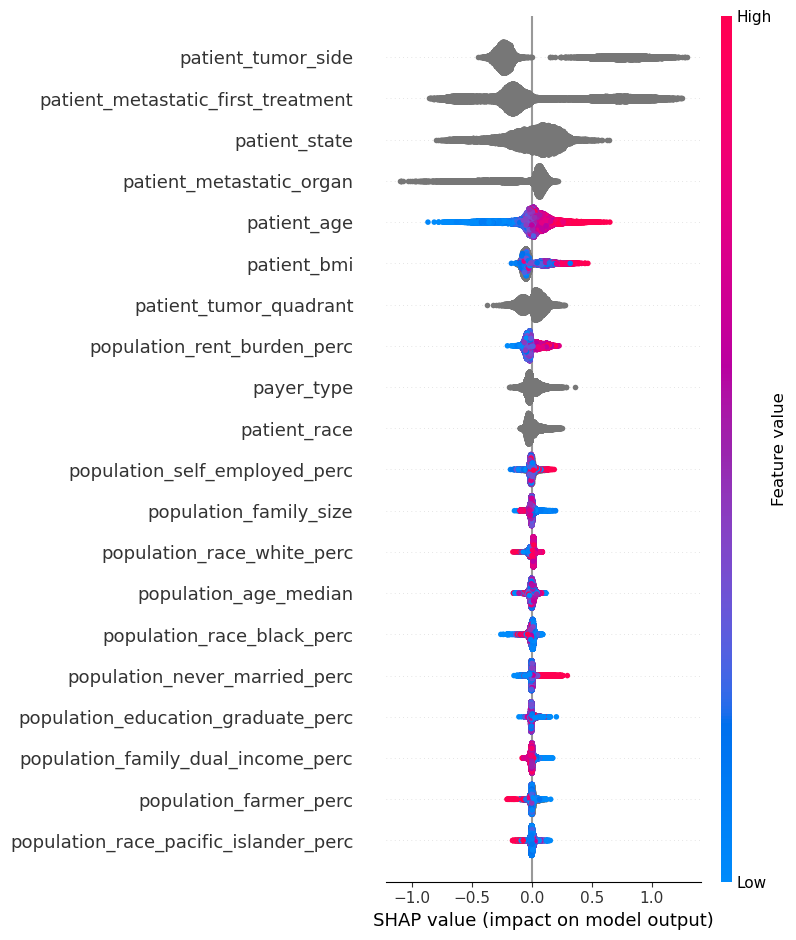

In [73]:
shap.summary_plot(shap_values, X)

In [74]:
# Ref: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html
for name in X_train.columns:
    shap.dependence_plot(name, shap_values.values, X)

TypeError: '<' not supported between instances of 'float' and 'str'